# Think Bayes - Chapter 4

Following A. B. Downey's book *Think Bayes*, but using Julia as opposed to Python

In [148]:
using Statistics, Distributions, Plots, Printf

**Euro problem:** When spun 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. Is this suspicious 

## Binomial distribution

Probability mass function for the number of heads of a fair coin

In [3]:
function make_binomial(toss_count, heads_prob=0.5)
    """
    Generate PMF for binomial distribution with certain number of tosses
    """
    return pdf.(Binomial(toss_count, heads_prob), Vector(0:toss_count))
end

make_binomial (generic function with 2 methods)

Most likely head-count is 150

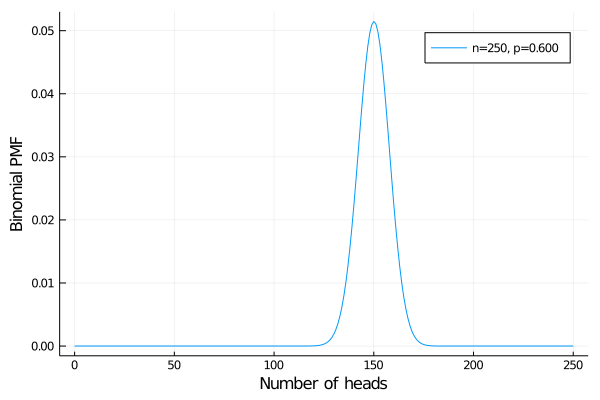

In [4]:
toss_count = 250
heads_prob = 0.6

heads_arr = Vector(0:toss_count)
binom_pmf_arr = make_binomial(toss_count, heads_prob)

@printf("Most likely head-count is %d", heads_arr[argmax(binom_pmf_arr)])

plot(
    heads_arr,
    binom_pmf_arr,
    xlabel="Number of heads",
    ylabel="Binomial PMF",
    label=@sprintf("n=%d, p=%.3f", toss_count, heads_prob)
)

## Bayesian estimation

Want to test the hypothesis of $H_p$ with heads probability being $p$. 

The starting point, i.e. prior is $P_0\left(p\right)=1/p$, i.e. we are assuming equal probability of any value for the heads probability.

We then take the first measurement by tossing a coin and get $M_1=H$, so the posterior probability of $p$ is:

$$
\begin{align}
P_1\left(p \,|\, M_1\right) &=\frac{P\left(p,\, M_1\right)}{P\left(M_1\right)}\\
&= \frac{P\left(M_1\, | \, p\right) P\left(p\right)}{P\left(M_1\right)} \\
&=\frac{P\left(M_1\, | \, p\right) P_0\left(p\right)}{P\left(M_1\right)}
\end{align}
$$

Normalization can be handled by going through all possible hypothesis, since, by definition conditional probability is normalized, i.e. $\int dp P_1\left(p \,|\, M_1\right)=1$. Therefore:

$$
\begin{align}
1 &=\int dp \frac{P\left(M_1\, | \, p\right) P_0\left(p\right)}{P\left(M_1\right)} \\
P\left(M_1\right) &=\int dp P\left(M_1\, | \, p\right) P_0\left(p\right)
\end{align}
$$

So 

$$
\begin{align}
P_1\left(p \,|\, M_1\right) &=\frac{P\left(M_1\, | \, p\right) P_0\left(p\right)}{\int dp\, P\left(M_1\, | \, p\right) P_0\left(p\right)}
\end{align}
$$

Once the measurement has been made the probability changes $P_1\left(p \,|\, M_1\right) \to P_1\left(p \right)$ since measurement $M_1$ is now a certainty. Thus the update procedure is

$$
\begin{align}
P_i\left(p \,|\, M_i\right) &=\frac{P\left(M_{i-1}\, | \, p\right) P_{i-1}\left(p\right)}{\int dp\, P\left(M_{i-1}\, | \, p\right) P_{i-1}\left(p\right)} \\
P_i\left(p \,|\, M_i\right) &\to P_i\left(p \right)
\end{align}
$$

All we need to do now is, starting with the prior, to feed successive measurements $H\times 140\, T\times 110$. Will order matter? No since multiplication is commutative and normalization can be dropped until the very end.

In [98]:
heads_prob_arr = Array(0.001:0.001:0.999) # range of heads-prob being considered
heads_prob_likelihood_arr = ones(length(heads_prob_arr)) # likelihood of each
;

What is the probability of $H$ heads and $T$ tails, assuming binomial distribution with single-heads probability $p$?

$$
P\left(H-heads\,\&\,T-tails\,|\,p\right)=\left(\begin{array}\\H+T \\ H\end{array}\right) p^H.\left(1-p\right)^T=\frac{\left(H+T\right)!}{H!\,T!}\:p^H.\left(1-p\right)^T
$$

It is relatively easy to vectorize it for multiple $p$. Also it is useful to compute the log-probability

$$
\begin{align}
\log P\left(H-heads\,\&\,T-tails\,|\,p\right)&=\sum^{H+T}_{s=1} s - \sum^{H}_{s'=1} s' - \sum^{T}_{s''=1} s'' + H\cdot\log p + T\cdot \log \left(1-p\right) \\
&=\frac{\left(H+T\right)\cdot\left(H+T+1\right)-H\cdot\left(H+1\right)-T\cdot\left(T+1\right)}{2} + H\cdot\log p + T\cdot \log \left(1-p\right)
\end{align}
$$

The update is:

$$
\begin{align}
P_n\left(p\right)&=P\left(p|H_nT_n,\,H_{n-1}T_{n-1},\dots H_{1}T_{1}\right)\\
&=c_n P\left(H_nT_n|p\right)P_{n-1}\left(p\right) \\
&=c_n P\left(H_nT_n|p\right)P\left(p|H_{n-1}T_{n-1},\,H_{n-2}T_{n-2},\dots H_{1}T_{1}\right) \\
&=c_n P\left(H_nT_n|p\right) \cdot c_{n-1} P\left(H_{n-1}T_{n-1}|p\right)P_{n-2}\left(p\right) \\
&=\Pi_{k=1}^n c_{k} P\left(H_kT_k|p\right)\cdot P_{0}\left(p\right)
\end{align}
$$

Where $c_k$ do not depend on $p$ and $P_0\left(p\right)$ is the initial prior. Taking the $\log$:

$$
\begin{align}
\log P_n\left(p\right) &=\log P_0 + \sum_{k=1}^n\left( \log c_k + \log P\left(H_k T_k | p \right) \right) \\
\log P_n\left(p\right) &= q_n + \log P_0 + \log p \cdot \sum_{k=1}^n H_k + \log\left(1-p\right) \cdot \sum_{k'=1}^n T_{k'} \\
&=q'_n + log P_{n-1}\left(p\right) + \log p \cdot H_n + \log\left(1-p\right) \cdot T_{n}
\end{align}
$$

Where $q_n$ depends on $n$ as well as various $H,\,T$, but not on $p$, and can therefore be taken care of through normalization. 

In [139]:
function log_likelihood_update(
    heads_count, # number of heads
    tails_count, # number of tails
    prob_arr, # array of values of heads probability
    prior_log_lkhd_arr # array of likelihoods for each heads probability
)
    # update to get posterior
    post_log_lkhd_arr = 
        prior_log_lkhd_arr .+ log.(prob_arr) .* heads_count .+ log.(1 .- prob_arr) .* tails_count
    
    # normalize
    post_log_lkhd_arr = post_log_lkhd_arr .+ abs(maximum(tri_prior_arr))
    p_step = prob_arr[2] - prob_arr[1]
    norm_val = sum(exp.(post_log_lkhd_arr)) * p_step
    
    post_log_lkhd_arr = post_log_lkhd_arr .- log(norm_val)
    
    return post_log_lkhd_arr
    
end

log_likelihood_update (generic function with 1 method)

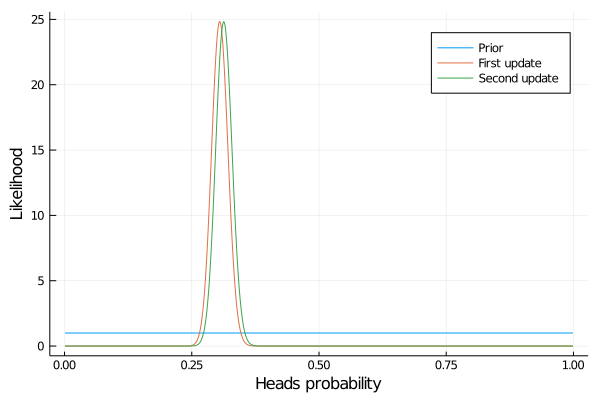

In [140]:
prior_LOG_likelihood_arr = log.(heads_prob_likelihood_arr)

#
heads1_count = 250
tails1_count = 570

post1_LOG_likelihood_arr = log_likelihood_update(
    heads1_count,
    tails1_count,
    heads_prob_arr,
    prior_LOG_likelihood_arr
)

#
heads2_count = 10
tails2_count = 1

post2_LOG_likelihood_arr = log_likelihood_update(
    heads2_count,
    tails2_count,
    heads_prob_arr,
    post1_LOG_likelihood_arr
)

#####################

plot(
    heads_prob_arr,
    exp.(prior_LOG_likelihood_arr),
    xlabel="Heads probability",
    ylabel="Likelihood",
    label="Prior"
)
#
plot!(
    heads_prob_arr,
    exp.(post1_LOG_likelihood_arr),
    xlabel="Heads probability",
    ylabel="Likelihood",
    label="First update"
)
#
plot!(
    heads_prob_arr,
    exp.(post2_LOG_likelihood_arr),
    label="Second update"
)


In [94]:
sum(exp.(prior_LOG_likelihood_arr))*(heads_prob_arr[2]-heads_prob_arr[1])

0.99

## Comapring different priors

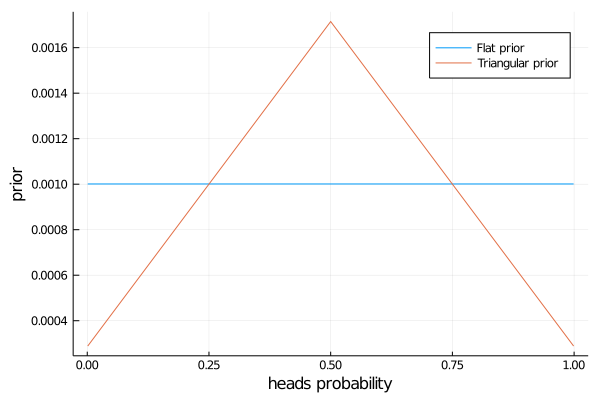

In [115]:
flat_prior_arr = ones(length(heads_prob_arr))
flat_prior_arr = flat_prior_arr / sum(flat_prior_arr)
#
tri_prior_arr = (0.1 + 0.5 .- abs.(0.5 .-heads_prob_arr))
tri_prior_arr = tri_prior_arr / sum(tri_prior_arr)

plot(
    heads_prob_arr, 
    flat_prior_arr,
    label="Flat prior",
    xlabel="heads probability",
    ylabel="prior"
)
#
plot!(
    heads_prob_arr,
    tri_prior_arr,
    label="Triangular prior"
)

Now apply the same data to the two priors

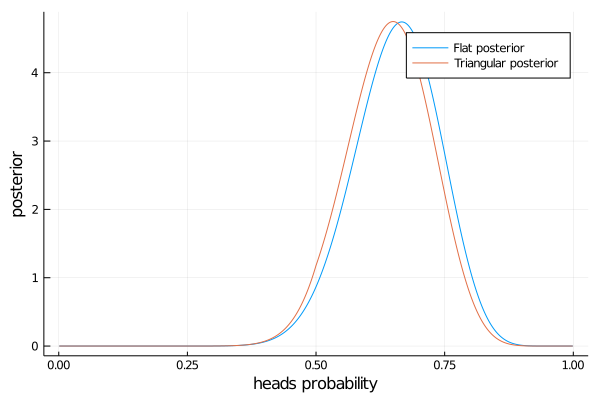

In [147]:
heads_count = 10
tails_count = 5

log_flat_post_arr = log_likelihood_update(
    heads_count,
    tails_count,
    heads_prob_arr,
    log.(flat_prior_arr)
)
#
log_tri_post_arr = log_likelihood_update(
    heads_count,
    tails_count,
    heads_prob_arr,
    log.(tri_prior_arr)
)

## repeat again
log_flat_post_arr = log_likelihood_update(
    heads_count,
    tails_count,
    heads_prob_arr,
    log_flat_post_arr
)
#
log_tri_post_arr = log_likelihood_update(
    heads_count,
    tails_count,
    heads_prob_arr,
    log_tri_post_arr
)


###
plot(
    heads_prob_arr, 
    exp.(log_flat_post_arr),
    label="Flat posterior",
    xlabel="heads probability",
    ylabel="posterior"
)
#
plot!(
    heads_prob_arr,
    exp.(log_tri_post_arr),
    label="Triangular posterior"
)

In [138]:
maximum(tri_prior_arr)

0.0017147756501857674